## Codes

### import

In [1]:
# import pandas as pd
# C:\Users\rrahman3\Miniconda3\envs\tf\python.exe -m pip install jupyterlab

import numpy as np
import random
import pickle
import logging

import collections
from collections import defaultdict, Counter

# import scipy.sparse as sp
# from sklearn.metrics import ndcg_score, dcg_score

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.autograd import Variable

import argparse
from time import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# from google.colab import drive

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

from tensorflow.keras import backend as K
from tensorflow import keras
# used to fix the tf error "ValueError: tf.function-decorated function tried to create variables on non-first call."
tf.config.run_functions_eagerly(True)
import logging
tf.get_logger().setLevel(logging.ERROR)

tf.__version__, tfp.__version__

import matplotlib.pyplot as plt
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.style.use('seaborn-whitegrid')
# import seaborn as sns
%matplotlib inline

import time

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

C:\Users\rrahman3\AppData\Local\Temp\1\ipykernel_12980\4190522189.py:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


### utils

In [2]:
# utils.py

def set_seed(seed, cuda=False):

    np.random.seed(seed)
    random.seed(seed)
#     if cuda:
#         torch.cuda.manual_seed(seed)
#     else:
#         torch.manual_seed(seed)

set_seed(2022)

### Interactions

In [3]:
# connet to Drive
data_root = ''
base_directory = '/content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/'
base_directory = 'C:\\Users\\rrahman3\\PycharmProjects\\UncertaintyProject'
class DriveConnection:
    def __init__(self):
#         from google.colab import drive
#         drive.mount('/content/drive')
        pass

    def get_root(self, data_location='Riyi'):
        # change working directory
        if data_location == 'Riyi':
            # %cd /content/drive/My Drive/ColabData/UncertaintyRecommenderSystem/RiyiQiu_Uncertainty_RecSys/data&script/
            # %ls
            data_root = '/content/drive/My Drive/ColabData/UncertaintyRecommenderSystem/RiyiQiu_Uncertainty_RecSys/data&script/'
            data_root = 'data'

        elif data_location == 'CosRec':
            # %cd /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/data
            data_root = base_directory + '/data/'
            data_root = 'data'

        else:
            # %cd /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/data
            data_root = '/content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/data'
            # data_root = '/content/drive/My Drive/Colab Notebooks/RuhaniRahman/UncertaintyRecommenderSystem/data'
            data_root = 'data'

        return data_root

class Instances:
    def __init__(self):
        self.sequences = None 
        self.users = None
        self.targets = None #movie ids
        self.item_samples = None
        self.y_true = None
        
    
    def shuffle(self):

        shuffle_indices = np.arange(len(self.sequences))
        np.random.shuffle(shuffle_indices)

        self.sequences = self.sequences[shuffle_indices]
        self.users = self.users[shuffle_indices]
        self.targets = self.targets[shuffle_indices]

        if self.item_samples is not None:
            self.item_samples = self.item_samples[shuffle_indices]
        if self.y_true is not None:
            self.y_true = self.y_true[shuffle_indices]
        
class Interactions:
    def __init__(self, data_root, sequence_length = 5, target_length = 1):
        self.user_interactions = []
        self.user_ratings = []
        self.train = Instances()
        self.test = Instances()
        self.data_root = data_root
        self.num_users = 0
        self.num_items = 0
        self.num_sequences = 0

        self.sequence_length = sequence_length
        self.target_length = target_length

    def data_preprocess(self):
        print('Root', self.data_root)
        self._read_file(self.data_root+'/ml-1m/train_set_sequences')
        self._read_file(self.data_root+'/ml-1m/test_set_sequences')
        self._read_file(self.data_root+'/ml-1m/val_set_sequences')

        self.user_interactions = np.array(self.user_interactions)
        self.user_ratings = np.array(self.user_ratings)

        self.num_users = self.user_interactions.shape[0]
        self.num_items = np.max(np.concatenate(self.user_interactions[:]))

        print('num_users = ', self.num_users)
        print('num_items = ', self.num_items)


        self.x_n_ratings = np.array([self.user_ratings[user_id].shape[0] for user_id in range (self.num_users)])
        self.x_var_ratings = np.array([np.var(self.user_ratings[user_id]) for user_id in range(self.num_users)])
        self.x_avg_ratings = np.array([np.mean(self.user_ratings[user_id]) for user_id in range(self.num_users)])

        with open(self.data_root+'/ml-1m/user_similarity.pkl','rb') as f:
            self.x_similarity = pickle.load(f)

        movie_mapping = {}
        with open(self.data_root + '/ml-1m/item_id_mapping','rb') as f:
            f.readline()
            for l in f:
                origin, new = l.strip().split()
                movie_mapping[int(new) + 1] = int(origin)

        # print(movie_mapping)
        movie_genres = {}
        with open(self.data_root + '/ml-1m/movies.dat','rb') as f:
            for l in f:
                # print(l)
                mid, _, genre = l.strip().decode('latin-1').split('::')
                # print(mid, genre)
                movie_genres[int(mid)] = genre
        # movie_genres

        self.x_n_genres = np.zeros(self.num_users)
        for user_id in range(self.num_users):
            genres = []
            for movie_id in self.user_interactions[user_id]:
                genres += movie_genres[movie_mapping[movie_id]].split('|')
            self.x_n_genres[user_id] = len(set(genres))

    def _read_file(self, file_path):
        with open(file_path, 'r') as fin:
            for line in fin:
                item_ratings = line.strip().split()[1:]
                item_ratings_np = np.array(item_ratings).astype(np.int64).reshape(-1,2)

                item_ratings_np[:, 0] += 1 ### Adding 1 to the item_id, 0 reads as padding
                item_ratings_np[:, 1] *= 2 ### Rating is multiplied by 2, now counts as 10

                ### users must have rated at least 15 items
                if item_ratings_np.shape[0] >= 15: 
                    self.user_interactions.append(item_ratings_np[:, 0])
                    self.user_ratings.append(item_ratings_np[:, 1])

    def create_test_train_instances(self):
        self._create_test_instances()
        self._create_train_instances()

    def _create_test_instances(self):

        ### Creating last item as prediction item
        self.test.targets = []

        ### Targets compaible with softmax output
        # for interactions in self.user_interactions:
        #     T = np.zeros(self.num_items)
        #     T[interactions[-self.target_length:]-1] = 1
        #     self.test.targets.append(T)
        # self.test.targets = np.array(self.test.targets).reshape(-1, self.num_items)
        # print('test.targets.shape:', len(self.test.targets))

        ### Test targets are compaible with sigmoid output and sparse softmax out
        for interactions in self.user_interactions:
            # self.test.targets.append(interactions[-self.target_length:])
            self.test.targets.append(interactions[-self.target_length:]-1)
        self.test.targets = np.array(self.test.targets).reshape(-1, self.target_length)
        print('test.targets.shape:', self.test.targets.shape)

        ### users
        self.test.users = np.arange(self.num_users).reshape(-1, 1)
        print('test.users.shape:', self.test.users.shape)

        ### 
        self.test.sequences = []
        for interaction in self.user_interactions:
            # interaction = interaction[:-self.target_length]
            if len(interaction) < self.sequence_length:
                num_paddings = self.sequence_length - len(interaction)
                interaction = np.pad(interaction, (num_paddings, 0), 'constant')
            else:
                interaction = interaction[-self.sequence_length:]

            self.test.sequences.append(interaction)
        self.test.sequences = np.array(self.test.sequences)
        print('test.sequences.shape:', self.test.sequences.shape)

    def _create_train_instances(self):
        max_sequence_length = self.sequence_length + self.target_length
        self.train.sequences = []
        self.train.users = []
        self.train.targets = []

        self.user_sequence_indexes = [list() for i in range(self.num_users)]

        sequence_index = 0
        for user_id, interaction in enumerate(self.user_interactions):
            # interaction = interaction[:-self.target_length]

            if len(interaction) < max_sequence_length:
                num_paddings = max_sequence_length - len(interaction)
                interaction = np.pad(interaction, (num_paddings, 0), 'constant')

                self._add_sequence(interaction[:self.sequence_length],
                                   user_id,
                                   interaction[-self.target_length:],
                                   sequence_index)
                sequence_index += 1
            
            else:
                for ind in range(len(interaction), max_sequence_length-1, -1):
                    temp_sequence = interaction[ind - max_sequence_length: ind]
                    self._add_sequence(temp_sequence[:self.sequence_length],
                                   user_id,
                                   temp_sequence[-self.target_length:],
                                   sequence_index)
                    sequence_index += 1

        self.train.sequences = np.array(self.train.sequences)
        self.train.users = np.array(self.train.users).reshape(-1,1)
        self.train.targets = np.array(self.train.targets)

        for user_id in range(self.num_users):
            self.user_sequence_indexes[user_id] = np.array(self.user_sequence_indexes[user_id])
        self.user_sequence_indexes = np.array(self.user_sequence_indexes)

        self.num_sequences = sequence_index

    
    def _add_sequence(self, seq, usr, target, sequence_index):
        self.train.sequences.append(seq)
        self.train.users.append(usr)

        # target_vector = np.zeros(self.num_items)
        # target_vector[target-1] = 1
        # self.train.targets.append(target_vector)

        # self.train.targets.append(target)
        self.train.targets.append(target-1)
        self.user_sequence_indexes[usr].append(sequence_index)
        


def _generate_negative_samples(data, n):
    """
    Sample negative from a candidate set of each user. The
    candidate set of each user is defined by:
    {All Items} \ {Items Rated by User}

    Parameters
    ----------

    users: array of np.int64
        sequence users
    interactions: :class:`spotlight.interactions.Interactions`
        training instances, used for generate candidates
    n: int
        total number of negatives to sample for each sequence
    """
    negative_candidate_item = dict()
    users_ = data.train.users.squeeze()
    negative_samples = np.zeros((users_.shape[0], n), np.int64)

    ### set candidate items for negetive samples for each user
    all_items = np.arange(data.num_items - 1) + 1  # 0 for padding
    for user_id in range(data.num_users):
        negative_candidate_item[user_id] = list(set(all_items) - set(data.user_interactions[user_id]))

    for i, u in enumerate(users_):
        for j in range(n):
            negative_item = negative_candidate_item[u]
            negative_samples[i, j] = negative_item[np.random.randint(len(negative_item))]

    return negative_samples

# returns both positive and negative targets with their labels
def get_target_samples(data, num_negative_samples=1):
    negatives_np = _generate_negative_samples(data, num_negative_samples)
    data.train.item_samples = np.concatenate((data.train.targets, negatives_np), axis=1)

    y_pos = np.ones(data.train.targets.shape[0]).reshape(-1,1)
    y_neg = np.zeros((negatives_np.shape[0], num_negative_samples)).reshape(-1,num_negative_samples)

    data.train.y_true = np.concatenate((y_pos, y_neg), axis=1)

    # return item_samples, y_true



### Instance Spliter

In [4]:
class InstanceSpliter:

    def __init__(self, data, k_fold = 5):
        self.data = data
        self.k_fold = k_fold

    def generate_folds(self):
        n_user_fold = self.data.num_users // self.k_fold
        user_ids = np.arange(self.data.num_users)
        np.random.shuffle(user_ids)

        ### Find folds for users
        self.user_fold_indexes = []
        for fold in range(self.k_fold):
            self.user_fold_indexes.append(user_ids[fold*n_user_fold : (fold+1)*n_user_fold])
        self.user_fold_indexes = np.array(self.user_fold_indexes)

    def get_sequence_indexes(self, fold_indexes):
        # print(fold_indexes)
        return np.concatenate(self.data.user_sequence_indexes[fold_indexes])

    def get_sequence(self, sequence_indexes, isTest=False):
        _instances = Instances()
        if isTest:
            _split_instances = self.data.test
        else:
            _split_instances = self.data.train

        _instances.users = _split_instances.users[sequence_indexes]
        _instances.sequences = _split_instances.sequences[sequence_indexes]
        _instances.targets = _split_instances.targets[sequence_indexes]
        if not isTest:
            if _instances.item_samples is not None:
                _instances.item_samples = _split_instances.item_samples[sequence_indexes]
            if _instances.y_true is not None:
                _instances.y_true = _split_instances.y_true[sequence_indexes]

        return _instances

    def split_data(self, fold_id=0):
        if fold_id >= self.k_fold:
            raise Exception('Fold Id must be less than the k_fold')

        test_user_indexes = self.user_fold_indexes[fold_id]
        train_user_indexes = np.array(list(set(np.arange(self.data.num_users)) - set(self.user_fold_indexes[fold_id])))

        return self.create_split(train_user_indexes, test_user_indexes)
        
    def create_split(self, train_user_indexes, test_user_indexes):    
        train_sequence_indexes = self.get_sequence_indexes(train_user_indexes)
        validation_sequence_indexes = self.get_sequence_indexes(test_user_indexes)

        train_set = self.get_sequence(train_sequence_indexes)
        validation_set = self.get_sequence(validation_sequence_indexes)
        test_set = self.get_sequence(test_user_indexes, isTest=True)

        # if len(set(train_set.users.squeeze()).intersection(set(test_set.users.squeeze())))==0:
        # if len(set(train_user_indexes).intersection(set(test_user_indexes))) == 0:
        #     print('Well Done')
        # else:
        #     print('Error Splitting')
        print(train_set.users.shape, validation_set.users.shape, np.unique(train_set.users.squeeze()).shape, test_set.users.shape)

        train_set.shuffle()
        validation_set.shuffle()
    
        return train_set, validation_set, test_set

    def split_within_user_strategy(self, fold_id=0, data_point_kept=1, name='most_recent'):
        pass

    '''
    isMost: True will return the users that meet the criteria higher than the threshold, False will do the oppostie
    For example, if isMost=True, and threshold=7.5 and the user wants the nicest user,
    The method will choose the data between user data reduction technique in such a way that it will take the 'p' percent of users whose average ratings is higher than the threshold 7.5
    and take all the users whose average ratings is less than the threshold.
    For the training set, it will only take the users whose given average ratings are higher than the threshold 7.5

    Riyi Qui set the threshold for different user data type:
        Nicest User --> Average Ratings > 7.5 (x_avg_ratings > 7.5) 
            #threshold=7.50, split_array=data.x_avg_ratings, isMost=True, name='Nicest User'
        Harshest User --> Average Ratings <= 7.5 (x_avg_ratings <= 7.5) 
            #threshold=7.50, split_array=data.x_avg_ratings, isMost=False, name='Harshest User'

        Most Active User --> Number of Ratings > 100 (x_n_ratings > 100) 
            #threshold=100.00, split_array=data.x_n_ratings, isMost=True, name='Most Active User'
        Least Active User --> Number of Ratings <= 100 (x_n_ratings <= 100) 
            #threshold=100.00, split_array=data.x_n_ratings, isMost=False, name='Least Active User'

        Most Typical User --> Similarity Score > 0.13 (x_similarity > 0.13) 
            #threshold=0.13, split_array=data.x_similarity, isMost=True, name='Most Typical User'
        Least Typical User --> Similarity Score <= 0.13 (x_similarity <= 0.13) 
            #threshold=0.13, split_array=data.x_similarity, isMost=False, name='Least Typical User'

        Most Consistent User --> Varience Ratings > 4 (x_var_ratings > 4) 
            #threshold=4.00, split_array=data.x_var_ratings, isMost=True, name='Most Consistent User'
        Least Consistent User --> Varience Ratings <= 4 (x_var_ratings <= 4) 
            #threshold=4.00, split_array=data.x_var_ratings, isMost=False, name='Least Consistent User'

        Most Open Minded User --> Number of Genres > 16 (x_n_genres > 4) 
            #threshold=16.00, split_array=data.x_n_genres, isMost=True, name='Most Open Minded User'
        Least Open Minded User --> Number of Genres <= 16 (x_n_genres <= 4) 
            #threshold=16.00, split_array=data.x_n_genres, isMost=False, name='Least Open Minded User'

    '''

    # def split(self, data, split_array, fold_id=0, threshold=7.5, retained_parcent=0.50, isMost=True, name='nicest user'):
    def split_between_user_strategy(self, between_users, fold_id=0, retained_parcent=0.50, name='nicest'):

        threshold = between_users[name]['threshold']
        isMost = between_users[name]['isMost']
        split_array = between_users[name]['split_array']
        print(name, threshold, isMost, split_array)

        
        test_user_indexes = self.user_fold_indexes[fold_id]
        if isMost:
            test_user_indexes = test_user_indexes[np.where(split_array[test_user_indexes] > threshold)[0]]
        else:
            test_user_indexes = test_user_indexes[np.where(split_array[test_user_indexes] <= threshold)[0]]
        # print(test_user_indexes)
        test_fold_indexes = self.user_fold_indexes[fold_id]
        if isMost:
            idx_non_target_user = np.where(split_array <= threshold)[0]
            idx_target_user = np.where(split_array > threshold)[0]
        else:
            idx_non_target_user = np.where(split_array > threshold)[0]
            idx_target_user = np.where(split_array <= threshold)[0]

        idx_non_target_user = np.array(list(set(idx_non_target_user) - set(test_fold_indexes)))
        idx_target_user = np.array(list(set(idx_target_user) - set(test_user_indexes)))
        idx_target_user = np.random.permutation(idx_target_user)[:int(len(idx_target_user)*retained_parcent)]
        train_user_indexes = np.concatenate([idx_non_target_user, idx_target_user])
        
        return self.create_split(train_user_indexes, test_user_indexes)


def init(seed=2022, sequence_length=10, target_length=1, k_fold=5):

    data_root = DriveConnection().get_root('CosRec') #['Riyi', 'CosRec']
    set_seed(seed)

    # load dataset
    instances = Interactions(data_root, sequence_length=sequence_length, target_length=target_length)
    instances.data_preprocess()
    instances.create_test_train_instances()

    # get_target_samples(instances, num_negative_samples=1)

    instance_spliter = InstanceSpliter(data=instances, k_fold=k_fold)
    instance_spliter.generate_folds()

    return instances, instance_spliter

In [5]:
data, spliter = init(
                     sequence_length=100,
                     target_length=1,
                     seed=2022,
                     k_fold=5
)
train_instances, validation_instances, test_instances = spliter.split_data(fold_id=3)

Root data
num_users =  6040
num_items =  3416
test.targets.shape: (6040, 1)
test.users.shape: (6040, 1)
test.sequences.shape: (6040, 100)
(450972, 1) (104477, 1) (4832,) (1208, 1)


### Uncertainty Calculations

In [12]:
def CustomSparseCategoricalCrossentropyLoss(y_true, y_pred):
    T = 10  
    varience = y_pred[:, -1]
    before_softmax = y_pred[:, :-1]

    std = tf.sqrt(varience)
    dist = tfd.Normal(loc=K.zeros_like(std), scale=std)

    iterable = K.variable(np.ones(T))
    monte_carlo_results = K.map_fn(crossentropy_loss(y_true, before_softmax, dist, data.num_items), elems=iterable, name='monte_carlo_results')
    variance_loss = K.mean(monte_carlo_results, axis=0)

    return K.log(variance_loss)

def crossentropy_loss(y_true, y_pred, dist, n_category):
    def map_fn(i):
        std_samples = K.transpose(dist.sample(n_category))
        # std_samples = K.reshape(std_samples, shape=(tf.shape(y_pred)[0], n_category))
        distorted_loss = K.sparse_categorical_crossentropy(y_true, y_pred + std_samples, from_logits=True) #from_logis=True --> applies softmax first
        return K.exp(distorted_loss)
    return map_fn

def CustomSparseTopKCategoricalAccuracy(y_true, y_pred):

    varience = tf.reshape(y_pred[:,-1], (-1,1))
    y_pred = y_pred[:,:-1]
    y_pred = tf.nn.softmax(y_pred)

    m = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20)
    m.update_state(y_true, y_pred)
    return m.result().numpy()

In [13]:
epsilon = 0.000001

def montecarlo_prediction(model, test_instances, T=100):
    predictions = np.array([model.predict(test_instances.sequences, verbose=0) for _ in range(T)]) #(T, batch_size, (num_items+softplus))
    # print(predictions.shape)
    prediction_probabilities = np.mean(predictions, axis=0) #(T, batch_size, (num_items+softplus))
    # print(prediction_probabilities.shape)
    prediction_probabilities = prediction_probabilities[:, :-1] #(batch_size, num_items)
    # print(predictions.shape)
    softmax_predictions = tf.nn.softmax(prediction_probabilities)
    prediction_variances = np.apply_along_axis(predictive_entropy, axis=1, arr=softmax_predictions) #(batch_size, 1), varience of each user
    # print(prediction_variances.shape)

    return (prediction_probabilities, prediction_variances)

def predictive_entropy(prob):
    return -1 * np.sum(np.log(prob+epsilon) * (prob))

### Recommendation Models

#### CosRec

In [ ]:
class CosRec:
    def __init__(self, data=None, sequence_length=10, T=10):
        self.T = T
        if not data:
            self.sequence_length = sequence_length
            self.num_users = 6040
            self.num_items = 3416        # tf.keras.layers.InputLayer((28, 28, 1)),
        else:
            self.sequence_length = data.sequence_length
            self.num_users = data.num_users
            self.num_items = data.num_items        # tf.keras.layers.InputLayer((28, 28, 1)),

    def get_model(self, isDropoutTraining=False):
        embed_dim = 50 #d
        fc_dim = 150
        ac_fc = 'tanh'
        drop_prob = 0.5
        d = 50
        block_num = 2
        block_dim = [128, 256] #[2*embed_dim, 128, 256]

        seq_input = tf.keras.layers.Input(shape=(self.sequence_length,), name='seq_input')
        user_input = tf.keras.layers.Input(shape=(1,), name='user_input')
        item_input = tf.keras.layers.Input(shape=(1,), name='item_input')



        # (None, 1, 50)
        user_embedding = tf.keras.layers.Embedding(
            input_dim = self.num_users, 
            output_dim = embed_dim, 
            name='user_embedding',
            embeddings_initializer='uniform',
            embeddings_regularizer=tf.keras.regularizers.L2(0)
        )(user_input)
        
        # (None, 1, 200)
        # item_embedding = tf.keras.layers.Embedding(
        #     input_dim = self.num_items, 
        #     output_dim = embed_dim+fc_dim, 
        #     name='item_embedding',
        #     embeddings_initializer='uniform',
        #     embeddings_regularizer=tf.keras.regularizers.L2(0)
        # )

        # (None, 5, 50)
        seq_embedding = tf.keras.layers.Embedding(
            input_dim = self.num_items, 
            output_dim = embed_dim,
            name='seq_embedding',
            embeddings_initializer='uniform',
            embeddings_regularizer=tf.keras.regularizers.L2(0)
        )(seq_input)

        # seq_var = tf.keras.layers.Input(shape=(5,), name='seq_var')
        # print(seq_var.shape)

        print('user_embedding.shape = ', user_embedding.shape) 
        print('seq_embedding.shape = ', seq_embedding.shape) 

        usr_emb = tf.repeat(user_embedding, [self.sequence_length], axis=1)

        user_embed = tf.squeeze(user_embedding, axis=1)
        print('user_embed.shape = ', user_embed.shape)

        item_i = tf.expand_dims(seq_embedding, axis = 1) #(batch_size, 1, seq_len, embed_dm)
        item_i = tf.repeat(item_i, [self.sequence_length], axis=1) #(batch_size, seq_len, seq_len, embed_dm)
        item_j = tf.expand_dims(seq_embedding, axis = 2) #(batch_size, seq_len, 1, embed_dm)
        item_j = tf.repeat(item_j, [self.sequence_length], axis=2) #(batch_size, seq_len, seq_ln, embed_dm)

        print('item_i.shape = ', item_i.shape)
        print('item_j.shape = ', item_j.shape)

        conv_layer = tf.keras.layers.Concatenate(axis=-1)([item_i, item_j]) #(batch_size, seq_len, seq_ln, 2*embed_dm)
        print('concatenate_layer.shape = ', conv_layer.shape)

        # # conv_layer = all_embed
        # # out = tf.keras.layers.Permute((3,1,2))(all_embed)
        # print('conv_layer.shape = ', conv_layer.shape)

        for i in range(block_num):
            conv_layer = tf.keras.layers.Conv2D(block_dim[i], kernel_size=1, strides=(1, 1), activation='relu')(conv_layer)
            print('conv_layer.shape = ', conv_layer.shape)
            conv_layer = tf.keras.layers.Conv2D(block_dim[i], kernel_size=3, activation='relu')(conv_layer)
            print('conv_layer.shape = ', conv_layer.shape)

        avg_pool_layer = tf.keras.layers.AveragePooling2D(pool_size=(1,1))(conv_layer)

        print('avg_pool_layer.shape = ', avg_pool_layer.shape)

        avg_pool_layer = tf.keras.layers.Flatten()(avg_pool_layer) #(batch_size, seq_len-kernel_size*len(block_num), seq_ln-kernel_size*len(block_num), block_dim[-1])

        print('flatten_avg_pool_layer.shape = ', avg_pool_layer.shape)

        fully_connected_layer = tf.keras.layers.Dense(fc_dim, 
                                        activation='relu',
                                        #    kernel_initializer = tf.keras.initializers.LecunUniform(), 
                                        #    name = "prediction"
                                        )(avg_pool_layer) # #(batch_size, seq_len * seq_ln * block_dim[-1])

        print('fully_connected_layer.shape = ', fully_connected_layer.shape)
        
        dropout_layer = tf.keras.layers.Dropout(drop_prob)(fully_connected_layer, training=isDropoutTraining)
        # print('dropout_layer.shape = ', dropout_layer.shape)

        
        out = tf.keras.layers.Concatenate()([dropout_layer, tf.squeeze(user_embedding, axis=1)])
        # print('out.shape = ', out.shape)

        # Dropout Layer
        out = tf.keras.layers.Dropout(drop_prob)(out, training=isDropoutTraining)


        variance_layer = tf.keras.layers.Dense(1)(out)
        variance_layer = tf.keras.layers.Activation(activation=tf.nn.softplus,name='variance_layer')(variance_layer)

        W2 = tf.keras.layers.Embedding(input_dim = self.num_items, output_dim = embed_dim+fc_dim, 
                                                name='item_embedding_W2',
                                                embeddings_initializer='uniform',
                                                embeddings_regularizer=tf.keras.regularizers.L2(0)
                                                )(item_input)
        B2 = tf.keras.layers.Embedding(input_dim = self.num_items, output_dim = 1, 
                                                name='item_embedding_B2',
                                                embeddings_initializer=tf.keras.initializers.Zeros()
                                                )(item_input)
        

        # print('W2.shape = ', W2.shape)
        # print('B2.shape = ', B2.shape)
        # print(tf.expand_dims(out, axis=2).shape)
        out = B2 + tf.linalg.matmul(W2, tf.expand_dims(out, axis=2))
        # print('out.shape 1 = ', out.shape)
        out = tf.squeeze(out, axis = 2)
        # print('out.shape 2 = ', out.shape)
        # print(out)
        # logits = tf.keras.layers.Dense(3416)(dense_128)
        # sigmoid_output = out
        sigmoid_output = tf.keras.layers.Activation(activation=tf.nn.sigmoid,name='sigmoid_output')(out)
        logits_variance = tf.keras.layers.concatenate([sigmoid_output, variance_layer], name='logits_variance')
        # logits_variance = tf.keras.layers.concatenate([variance_layer], name='logits_variance')

        model = tf.keras.Model(
                                inputs=[seq_input, user_input, item_input], 
                                outputs=[logits_variance, sigmoid_output]
                            )
        
        # model = tf.keras.Model(inputs=[seq_input, user_input, item_input], outputs=[sigmoid_output])

        # model = tf.keras.models.Model(inputs=[user_input, item_input], 
        #                                 outputs=prediction)

        ### model compile
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, decay=1e-4),
            loss={
                'logits_variance': bayesian_binary_crossentropy(T=self.T),
                'sigmoid_output': 'binary_crossentropy'
            },
            # metrics={
            #     'logits_variance': bayesian_binary_crossentropy(100),
            #     'sigmoid_output': tf.keras.metrics.binary_crossentropy
            # },
            loss_weights={
                'logits_variance': 0.5, 
                'sigmoid_output': 1.0
            }
        )

        return model


model = CosRec(data, T=100).get_model()
model.summary()

user_embedding.shape =  (None, 1, 50)
seq_embedding.shape =  (None, 200, 50)
user_embed.shape =  (None, 50)
item_i.shape =  (None, 200, 200, 50)
item_j.shape =  (None, 200, 200, 50)
concatenate_layer.shape =  (None, 200, 200, 100)
conv_layer.shape =  (None, 200, 200, 128)
conv_layer.shape =  (None, 198, 198, 128)
conv_layer.shape =  (None, 198, 198, 256)
conv_layer.shape =  (None, 196, 196, 256)
avg_pool_layer.shape =  (None, 196, 196, 256)
flatten_avg_pool_layer.shape =  (None, 9834496)


ResourceExhaustedError: ignored

In [ ]:
x = tf.random.normal((128, 200, 50), dtype=tf.float32)
x = tf.keras.layers.Permute((2, 1))(x) #(128, 50, 200)
x = tf.expand_dims(x, axis=2) #(128, 50, 1, 200)
x = tf.keras.layers.ZeroPadding2D(padding=1)(x)
x = tf.keras.layers.Conv1D(50, kernel_size=3, dilation_rate=1)(x)

x = tf.squeeze(x, axis=2) #(10, 50, 1, 200)
x = tf.keras.layers.Permute((2, 1))(x) #(128, 50, 200)
print(x.shape)



(128, 50, 52)


In [ ]:
divergence_fn = lambda q, p, _: tfd.kl_divergence(q, p) / train_instances.sequences.shape[0]

tfpl.Convolution2DReparameterization(
           input_shape = (128,6), filters = 8, kernel_size = 16,
           activation = 'relu',
           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
           kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
           kernel_divergence_fn = divergence_fn,
           bias_prior_fn = tfpl.default_multivariate_normal_fn,
           bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
           bias_divergence_fn = divergence_fn)

#### NextItNet

In [18]:
# divergence_fn = lambda q, p, _: tfd.kl_divergence(q, p) / train_instances.sequences.shape[0]

class NextItNet:
    def __init__(self, data=None, sequence_length=10, T=10):
        self.T = T
        self.data = data
        if not data:
            self.sequence_length = sequence_length
            self.num_users = 6040
            self.num_items = 3416        # tf.keras.layers.InputLayer((28, 28, 1)),
        else:
            self.sequence_length = data.sequence_length
            self.num_users = data.num_users
            self.num_items = data.num_items      # Consider padding 0 a prediction

    def get_model(self, isDropoutTraining=False):
        divergence_fn = lambda q, p, _: tfd.kl_divergence(q, p) / self.data.train.sequences.shape[0]
        embed_dim = 64          # 256
        embed_size = 64         # 256
        dilations = [1, 2, 4]   # [1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]
        residual_channels = 32  # 256
        kernel_size = 3         # 3

        seq_input = tf.keras.layers.Input(shape=(self.sequence_length,), name='seq_input')

        # (batch_size, sequence_length, embed_dim) --> (None, 100, 64)
        seq_embedding = tf.keras.layers.Embedding(
            input_dim = self.num_items+1, 
            output_dim = embed_size,
            name='seq_embedding',
            embeddings_initializer='uniform',       #embeding.weight.data.uniform_(-stdv, stdv) # important initializer, stdv = np.sqrt(1. / self.item_size)
            embeddings_regularizer=tf.keras.regularizers.L2(0)
        )(seq_input) #(batch_size, seq_len, embed_dim) = (None, 100, 64)

        conv_layer = seq_embedding
        # conv_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(seq_embedding) #(batch_size, seq_len, embed_dim, 1) (None, 100, 64, 1)

        for dilation in dilations: #[1, 2, 4]

            conv_layer = tfp.layers.Convolution1DReparameterization(
            # conv_layer = tf.keras.layers.Conv1D(
                    residual_channels, 
                    kernel_size=kernel_size, 
                    dilation_rate=dilation, 
                    padding='valid', 
                    activation='relu',
                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                    kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                    kernel_divergence_fn = divergence_fn,
                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                    bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                    bias_divergence_fn = divergence_fn,   
                )(conv_layer) # (batch_size, seq_len, embed_dim, residual_channels) = (None, 100, 62, 32), (None, 100, 54, 32), (None, 100, 38, 32)

            # conv_layer = tfp.layers.Convolution1DReparameterization(
            # # conv_layer = tf.keras.layers.Conv1D(
            #         residual_channels, 
            #         kernel_size=kernel_size, 
            #         dilation_rate=dilation * 2, 
            #         padding='valid', 
            #         activation='relu',
            #         kernel_prior_fn = tfpl.default_multivariate_normal_fn,
            #         kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
            #         kernel_divergence_fn = divergence_fn,
            #         bias_prior_fn = tfpl.default_multivariate_normal_fn,
            #         bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
            #         bias_divergence_fn = divergence_fn,   
            #     )(conv_layer) # (batch_size, seq_len, embed_dim, residual_channels) = (None, 100, 58, 32), (None, 100, 46, 32), (None, 100, 22, 32)
                

        flatten_layer = tf.reshape(conv_layer[:, -1,], (-1, residual_channels)) # (batch_size, embed_dim) = (None, 32)
        # fully_connected_layer = tf.keras.layers.Dense(residual_channels)(flatten_layer)
        variance_layer = tf.keras.layers.Dense(1, activation='softplus',name='variance')(flatten_layer)


        fully_connected_layer = tf.keras.layers.Dense(self.num_items)(flatten_layer) # (batch_size, num_items) = (None, 3417)

        # softmax_output = tf.keras.layers.Activation(activation=tf.nn.softmax,name='softmax_output')(fully_connected_layer)
        # logits_variance = tf.keras.layers.concatenate([softmax_output, variance_layer], name='logits_variance')
        logits_variance = tf.keras.layers.concatenate([fully_connected_layer, variance_layer], name='logits_variance')

        model = tf.keras.Model(
                                inputs=seq_input, 
                                outputs=logits_variance,
                                # outputs=logits_variance,
                            )
        ### model compile
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, decay=1e-4),
            loss=CustomSparseCategoricalCrossentropyLoss,
            metrics=[CustomSparseTopKCategoricalAccuracy],
        )
        
        return model

model = NextItNet(data, T=100).get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 seq_embedding (Embedding)      (None, 100, 64)      218688      ['seq_input[0][0]']              
                                                                                                  
 conv1d_reparameterization_3 (C  (None, 98, 32)      12352       ['seq_embedding[0][0]']          
 onv1DReparameterization)                                                                         
                                                                                                  
 conv1d_reparameterization_4 (C  (None, 94, 32)      6208        ['conv1d_reparameterization

In [ ]:
max_epochs = 10
verbose = 1
batch_size = 512

history = model.fit(
        x = train_instances.sequences, 
        y = train_instances.targets,
        
        epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            validation_instances.sequences, 
            validation_instances.targets
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )

Epoch 1/10
712/881 [=======================>......] - ETA: 1:49 - loss: 7.4588 - CustomSparseTopKCategoricalAccuracy: 0.0493

In [ ]:
history.history

{'loss': [7.136663913726807,
  6.515041828155518,
  6.266941070556641,
  6.146278381347656,
  6.069009304046631,
  6.013511657714844,
  5.970608234405518,
  5.935953617095947,
  5.904685020446777,
  5.879324436187744,
  5.855558395385742,
  5.8357439041137695,
  5.817441940307617,
  5.800481796264648,
  5.786498546600342,
  5.771807670593262,
  5.759812355041504,
  5.747171878814697,
  5.735742092132568,
  5.72706937789917,
  5.7169575691223145,
  5.707153797149658,
  5.698800086975098,
  5.690714359283447,
  5.6825432777404785,
  5.675997734069824,
  5.6681389808654785,
  5.661430835723877,
  5.655560493469238,
  5.649385929107666,
  5.642879486083984,
  5.638031005859375,
  5.632722854614258,
  5.627090930938721,
  5.622797966003418,
  5.617997646331787,
  5.61323356628418,
  5.609047889709473,
  5.605047225952148,
  5.600159168243408,
  5.596489906311035,
  5.592360019683838,
  5.588875770568848,
  5.58595085144043,
  5.582059860229492,
  5.579258441925049,
  5.574853420257568,
  5.

In [ ]:
### Vanila NextItNet
class NextItNet:
    def __init__(self, data=None, sequence_length=10, T=10):
        self.T = T
        if not data:
            self.sequence_length = sequence_length
            self.num_users = 6040
            self.num_items = 3417        # tf.keras.layers.InputLayer((28, 28, 1)),
        else:
            self.sequence_length = data.sequence_length
            self.num_users = data.num_users
            self.num_items = data.num_items + 1      # Consider padding 0 a prediction

    def get_model(self, isDropoutTraining=False):
        embed_dim = 64
        embed_size = 64
        dilations = [1, 2, 4]
        residual_channels = 32
        kernel_size = 3

        seq_input = tf.keras.layers.Input(shape=(self.sequence_length,), name='seq_input')

        # (None, 5, 50)
        seq_embedding = tf.keras.layers.Embedding(
            input_dim = self.num_items, 
            output_dim = embed_size,
            name='seq_embedding',
            embeddings_initializer='uniform',
            embeddings_regularizer=tf.keras.regularizers.L2(0)
        )(seq_input) #(batch_size, seq_len, embed_dim) = (None, 100, 64)


        conv_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(seq_embedding) #(batch_size, seq_len, embed_dim, 1) (None, 100, 64, 1)

        for dilation in dilations: #[1, 2, 4]
            conv_layer = tf.keras.layers.Conv1D(
                    residual_channels, 
                    kernel_size=kernel_size, 
                    dilation_rate=dilation, 
                    padding='valid', 
                    activation='relu')(conv_layer) # (batch_size, seq_len, embed_dim, residual_channels) = (None, 100, 62, 32), (None, 100, 54, 32), (None, 100, 38, 32)

            conv_layer = tf.keras.layers.Conv1D(
                    residual_channels, 
                    kernel_size=kernel_size, 
                    dilation_rate=dilation*2, 
                    padding='valid', 
                    activation='relu')(conv_layer) # (batch_size, seq_len, embed_dim, residual_channels) = (None, 100, 58, 32), (None, 100, 46, 32), (None, 100, 22, 32)


        flatten_layer = tf.reshape(conv_layer[:, -1, -1], (-1, residual_channels)) # (batch_size, embed_dim) = (None, 32)
        # fully_connected_layer = tf.keras.layers.Dense(residual_channels)(flatten_layer)
        fully_connected_layer = tf.keras.layers.Dense(self.num_items)(flatten_layer) # (batch_size, num_items) = (None, 3417)

        softmax_output = tf.keras.layers.Activation(activation=tf.nn.softmax,name='softmax_output')(fully_connected_layer)

        model = tf.keras.Model(
                                inputs=seq_input, 
                                outputs=softmax_output,
                            )
        ### model compile
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, decay=1e-4),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20)],
        )
        
        return model

model = NextItNet(data, T=100).get_model()
model.summary()

seq_embedding.shape =  (None, 100, 64)
expand_dims.shape =  (None, 100, 64, 1)
dilation = 1 conv_layer.shape = (None, 100, 62, 32)
dilation = 1 conv_layer.shape = (None, 100, 58, 32)
dilation = 2 conv_layer.shape = (None, 100, 54, 32)
dilation = 2 conv_layer.shape = (None, 100, 46, 32)
dilation = 4 conv_layer.shape = (None, 100, 38, 32)
dilation = 4 conv_layer.shape = (None, 100, 22, 32)
flatten_layer.shape = (None, 32)
fully_connected_layer.shape = (None, 3417)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 seq_input (InputLayer)      [(None, 100)]             0         
                                                                 
 seq_embedding (Embedding)   (None, 100, 64)           218688    
                                                                 
 lambda (Lambda)             (None, 100, 64, 1)        0         
                                                        

In [ ]:
max_epochs = 50
verbose = 1
batch_size = 128

history = model.fit(
        x = train_instances.sequences, 
        y = train_instances.targets,
        
        epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            validation_instances.sequences, 
            validation_instances.targets
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
3456/3456 [==============================] - 471s 134ms/step - loss: 7.3997 - sparse_top_k_categorical_accuracy: 0.0509 - val_loss: 7.1325 - val_sparse_top_k_categorical_accuracy: 0.0891
Epoch 2/50
3456/3456 [==============================] - 462s 134ms/step - loss: 6.9979 - sparse_top_k_categorical_accuracy: 0.1115 - val_loss: 6.9635 - val_sparse_top_k_categorical_accuracy: 0.1205
Epoch 3/50
3456/3456 [==============================] - 461s 134ms/step - loss: 6.8737 - sparse_top_k_categorical_accuracy: 0.1299 - val_loss: 6.9133 - val_sparse_top_k_categorical_accuracy: 0.1313
Epoch 4/50
3456/3456 [==============================] - 461s 133ms/step - loss: 6.8105 - sparse_top_k_categorical_accuracy: 0.1408 - val_loss: 6.8841 - val_sparse_top_k_categorical_accuracy: 0.1394
Epoch 5/50
3456/3456 [==============================] - 462s 134ms/step - loss: 6.7692 - sparse_top_k_categorical_accuracy: 0.1481 - val_loss: 6.8701 - val_sparse_top_k_categorical_accuracy: 0.1432
Epoch 6/50

#### GRU

In [ ]:
class GRU:
    def __init__(self, data=None, sequence_length=10, T=10):
        self.T = T
        if not data:
            self.sequence_length = sequence_length
            self.num_users = 6040
            self.num_items = 3417        # tf.keras.layers.InputLayer((28, 28, 1)),
        else:
            self.sequence_length = data.sequence_length
            self.num_users = data.num_users
            self.num_items = data.num_items + 1        # tf.keras.layers.InputLayer((28, 28, 1)),
    
    '''
        dropout_flag is set to True when calculating epistemic uncertainty and it is set to False for aleatoric uncertainty calculations
        
    '''
    def get_model(self, drop_prob = 0.5, dropout_flag=True):
        embed_dim = 200

        seq_input = tf.keras.Input(shape=self.sequence_length,name='input')

        item_embedding = tf.keras.layers.Embedding(
            input_dim=self.num_items, 
            output_dim=embed_dim, 
            mask_zero=True)(seq_input)

        print('item_embedding.shape:', item_embedding.shape)

        item_embedding_dropout = tf.keras.layers.Dropout(drop_prob)(item_embedding, training=dropout_flag)
        gru_layer = tf.keras.layers.GRU(100)(item_embedding_dropout)
        print('gru_layer.shape:', gru_layer.shape)

        gru_dropout = tf.keras.layers.Dropout(drop_prob)(gru_layer, training=dropout_flag)
        print('dropout_layer.shape:', gru_dropout.shape)

        fully_connected_layer = tf.keras.layers.Dense(32, activation=tf.nn.relu)(gru_dropout)
        print('fully_connected_layer.shape:', fully_connected_layer.shape)

        fully_connected_dropout = tf.keras.layers.Dropout(drop_prob)(fully_connected_layer, training=dropout_flag)

        variance_layer = tf.keras.layers.Dense(1, activation='softplus',name='variance')(fully_connected_dropout)

        fully_connected_layer = tf.keras.layers.Dense(self.num_items)(fully_connected_dropout)
        # fully_connected_dropout = tf.keras.layers.Dropout(drop_prob)(fully_connected_layer, training=dropout_flag)

        softmax_output = tf.keras.layers.Activation(activation=tf.nn.softmax,name='softmax_output')(fully_connected_layer)

        logits_variance = tf.keras.layers.concatenate([softmax_output, variance_layer], name='logits_variance')


        model = tf.keras.Model(inputs=seq_input, outputs=logits_variance)
        # model = tf.keras.Model(inputs=seq_input, outputs=[logits_variance,softmax_output])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, decay=1e-4),
            loss=CustomSparseCategoricalCrossentropyLoss(),
            metrics=[CustomSparseTopKCategoricalAccuracy],
        )
        
        return model

model = GRU(data, T=100).get_model()
model.summary()

item_embedding.shape: (None, 100, 200)
gru_layer.shape: (None, 100)
dropout_layer.shape: (None, 100)
fully_connected_layer.shape: (None, 32)
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 100, 200)     683400      ['input[0][0]']                  
                                                                                                  
 dropout_33 (Dropout)           (None, 100, 200)     0           ['embedding_11[0][0]']           
                                                                                                  
 gru_11 (GRU)                   (None, 100)      

In [ ]:
max_epochs = 50
verbose = 1
batch_size = 1024

hist = model.fit(
        x = train_instances.sequences, 
        y = train_instances.targets,
        
        epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            validation_instances.sequences, 
            validation_instances.targets
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )

Epoch 1/50
 28/432 [>.............................] - ETA: 3:01 - loss: 8.0029 - CustomSparseTopKCategoricalAccuracy: 0.0201

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/dist-packages/keras/backend.py", line 4734, in <genexpr>
    for ta, out in zip(output_ta_t, flat_new_output))  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/tf_should_use.py", line 245, in wrapped
    error_in_function=error_in_function)


432/432 [==============================] - 217s 503ms/step - loss: 7.4935 - CustomSparseTopKCategoricalAccuracy: 0.0400 - val_loss: 7.1666 - val_CustomSparseTopKCategoricalAccuracy: 0.0751
Epoch 2/50
432/432 [==============================] - 216s 501ms/step - loss: 6.9908 - CustomSparseTopKCategoricalAccuracy: 0.0957 - val_loss: 6.9019 - val_CustomSparseTopKCategoricalAccuracy: 0.1094
Epoch 3/50
432/432 [==============================] - 217s 502ms/step - loss: 6.7776 - CustomSparseTopKCategoricalAccuracy: 0.1237 - val_loss: 6.7484 - val_CustomSparseTopKCategoricalAccuracy: 0.1294
Epoch 4/50
432/432 [==============================] - 220s 508ms/step - loss: 6.6576 - CustomSparseTopKCategoricalAccuracy: 0.1378 - val_loss: 6.6735 - val_CustomSparseTopKCategoricalAccuracy: 0.1374
Epoch 5/50
432/432 [==============================] - 215s 497ms/step - loss: 6.5880 - CustomSparseTopKCategoricalAccuracy: 0.1453 - val_loss: 6.6307 - val_CustomSparseTopKCategoricalAccuracy: 0.1442
Epoch 6/50


KeyboardInterrupt: ignored

In [ ]:
### Vanila GRU for Sequential Recommendation

class GRU:
    def __init__(self, data=None, sequence_length=10, T=10):
        self.T = T
        if not data:
            self.sequence_length = sequence_length
            self.num_users = 6040
            self.num_items = 3417        # tf.keras.layers.InputLayer((28, 28, 1)),
        else:
            self.sequence_length = data.sequence_length
            self.num_users = data.num_users
            self.num_items = data.num_items + 1        # tf.keras.layers.InputLayer((28, 28, 1)),
    
    '''
        dropout_flag is set to True when calculating epistemic uncertainty and it is set to False for aleatoric uncertainty calculations
        
    '''
    def get_model(self, drop_prob = 0.5, dropout_flag=True):
        embed_dim = 200

        seq_input = tf.keras.Input(shape=self.sequence_length,name='input')
        # item_input = tf.keras.layers.Input(shape=(1,), name='item_input')


        # dropout = tf.keras.layers.Dropout(drop_prob)(seq_input, training=dropout_flag)
        item_embedding = tf.keras.layers.Embedding(
            input_dim=self.num_items, 
            output_dim=embed_dim, 
            mask_zero=True)(seq_input)

        print('item_embedding.shape:', item_embedding.shape)

        item_embedding_dropout = tf.keras.layers.Dropout(drop_prob)(item_embedding, training=dropout_flag)
        gru_layer = tf.keras.layers.GRU(100)(item_embedding_dropout)
        print('gru_layer.shape:', gru_layer.shape)

        gru_dropout = tf.keras.layers.Dropout(drop_prob)(gru_layer, training=dropout_flag)
        print('dropout_layer.shape:', gru_dropout.shape)

        fully_connected_layer = tf.keras.layers.Dense(32, activation=tf.nn.relu)(gru_dropout)
        print('fully_connected_layer.shape:', fully_connected_layer.shape)

        fully_connected_dropout = tf.keras.layers.Dropout(drop_prob)(fully_connected_layer, training=dropout_flag)

        variance_layer = tf.keras.layers.Dense(1, activation='softplus',name='variance')(fully_connected_dropout)

        fully_connected_layer = tf.keras.layers.Dense(self.num_items)(fully_connected_dropout)
        # fully_connected_dropout = tf.keras.layers.Dropout(drop_prob)(fully_connected_layer, training=dropout_flag)

        softmax_output = tf.keras.layers.Activation(activation=tf.nn.softmax,name='softmax_output')(fully_connected_layer)

        logits_variance = tf.keras.layers.concatenate([softmax_output, variance_layer], name='logits_variance')


        model = tf.keras.Model(inputs=seq_input, outputs=softmax_output)
        # model = tf.keras.Model(inputs=seq_input, outputs=[logits_variance,softmax_output])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, decay=1e-4),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                # 'logits_variance': bayesian_categorical_crossentropy(100, max_movieid),
                # 'softmax_output': 'categorical_crossentropy'
            # },
            metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20)],
            # loss_weights={
            #     # 'logits_variance': 0.5, 
            #     'softmax_output': 1.
            # }
        )
        
        return model

model = GRU(data, T=100).get_model()
model.summary()

item_embedding.shape: (None, 100, 200)
gru_layer.shape: (None, 100)
dropout_layer.shape: (None, 100)
fully_connected_layer.shape: (None, 32)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 200)          683400    
                                                                 
 dropout_3 (Dropout)         (None, 100, 200)          0         
                                                                 
 gru_1 (GRU)                 (None, 100)               90600     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 32)           

In [ ]:
max_epochs = 50
verbose = 1
batch_size = 1024

history = model.fit(
        x = train_instances.sequences, 
        y = train_instances.targets,
        
        epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            validation_instances.sequences, 
            validation_instances.targets
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )

Epoch 1/50
432/432 [==============================] - 280s 649ms/step - loss: 6.5768 - sparse_top_k_categorical_accuracy: 0.1517 - val_loss: 6.6560 - val_sparse_top_k_categorical_accuracy: 0.1474
Epoch 2/50
432/432 [==============================] - 277s 643ms/step - loss: 6.5562 - sparse_top_k_categorical_accuracy: 0.1552 - val_loss: 6.6445 - val_sparse_top_k_categorical_accuracy: 0.1491
Epoch 3/50
432/432 [==============================] - 278s 644ms/step - loss: 6.5428 - sparse_top_k_categorical_accuracy: 0.1567 - val_loss: 6.6313 - val_sparse_top_k_categorical_accuracy: 0.1512
Epoch 4/50
432/432 [==============================] - 275s 638ms/step - loss: 6.5267 - sparse_top_k_categorical_accuracy: 0.1591 - val_loss: 6.6247 - val_sparse_top_k_categorical_accuracy: 0.1515
Epoch 5/50
432/432 [==============================] - 275s 636ms/step - loss: 6.5142 - sparse_top_k_categorical_accuracy: 0.1602 - val_loss: 6.6070 - val_sparse_top_k_categorical_accuracy: 0.1544
Epoch 6/50
432/432 [

KeyboardInterrupt: ignored

### Training

In [ ]:
def model_train(model, train, validation, verbose=1, max_epochs=10, batch_size=512):
    model.fit(
        [train_set.sequences, train_set.users, train_set.item_samples], 
        {
            'logits_variance':train_set.y_true,
            'sigmoid_output':train_set.y_true
        },
        # epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            [validation_set.sequences, validation_set.users, validation_set.item_samples], 
            {
                'logits_variance':validation_set.y_true,
                'sigmoid_output':validation_set.y_true
            },
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )
    return model




In [ ]:
def predict(model, test_set, data, verbose=1):
    y_pred_var, y_pred = model.predict(
        [
            test_set.sequences, 
            test_set.users, 
            np.repeat(np.atleast_2d(np.arange(data.num_items)), test_set.users.shape[0], axis=0)
        ], 
        verbose=verbose
    )
    return y_pred

def predict_mean(model, test_set, data, verbose=1):
    y_pred_var, y_pred = model.predict(
        [
            test_set.sequences, 
            test_set.users, 
            np.repeat(np.atleast_2d(np.arange(data.num_items)), test_set.users.shape[0], axis=0)
        ], 
        verbose=verbose
    )
    return y_pred
    # return y_pred/np.sum(y_pred, axis=1).reshape(-1, 1)

x = []
def count_hit(predictions, targets, _k, hit_count):
    for i, k in enumerate(_k):
        if k == 20:
            x.append(len(set(predictions[-k:]).intersection(set(targets))))
        if len(set(predictions[-k:]).intersection(set(targets))) > 0:
            hit_count[i] += 1

def calculate_hit_rate(data, test_set, y_pred):
    _k = [5, 10, 20, 25, 30, 50, 100]
    hit_count = [0] * len(_k)
    print(test_set.users.shape)
    for test_set_index, user_id in enumerate(test_set.users.squeeze()):

        # targets = data.test.targets[user_id] + data.user_interactions[user_id][:-(data.sequence_length+data.target_length)]
        targets = data.test.targets[user_id]
        predictions = np.argsort(y_pred[test_set_index].squeeze())
        # rated = set(data.user_interactions[user_id][:-data.target_length])
        rated = set(data.user_interactions[user_id]) - set(targets)
        predictions = [p for p in predictions if p not in rated]

        count_hit(predictions, targets, _k, hit_count)

    hr = [0] * len(_k)
    for i, k in enumerate(_k):
        hr[i] = hit_count[i]/test_set.users.shape[0]
        # print(hit_count[i], hr[i])
    return hr
    
def evaluate_model(model, data, test, verbose=1, batch_size=512):
    y_pred = predict(model, test, data, verbose)
    hit_rate = calculate_hit_rate(data, test, y_pred)
    return hit_rate

def evaluate_model_by_loading_weights(model_location, data, test, isDropout=False, verbose=1, batch_size=512):
    model = CosRec(data, T=10).get_model(isDropout)
    model.load_weights(model_location)
    return evaluate_model(model, data, test=test, verbose=verbose, batch_size=batch_size)

## Training Model with Full Data
model_saved_location = '/content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/CosRec/epistemic_uncertainty/'
def get_check_point_file_name(fold, epoch, folder_path='valina_full_model/'):

    model_check_point_location = model_saved_location + folder_path + 'fold_%i_epoch_%i'%(fold, epoch)
    print('Model saved at:', model_check_point_location)
    return model_check_point_location





### Test Code Block

In [ ]:
data, spliter = init(
                     sequence_length=200,
                     target_length=1,
                     seed=123,
                     k_fold=5
)
train_instances, validation_instances, test_instances = spliter.split_data(fold_id=3)

# model = NextItNet(data, T=100).get_model()


Mounted at /content/drive
Root /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


num_users =  6040
num_items =  3416
test.targets.shape: (6040, 1)
test.users.shape: (6040, 1)
test.sequences.shape: (6040, 200)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(271778, 1) (71456, 1) (4832,) (1208, 1)


In [ ]:
model = NextItNet(data, T=100).get_model()
model.summary()

seq_embedding.shape =  (None, 200, 256)
(256,)
dilation = 1 conv_layer.shape = (None, 198, 256)
dilation = 1 conv_layer.shape = (None, 194, 256)
dilation = 4 conv_layer.shape = (None, 186, 256)
dilation = 4 conv_layer.shape = (None, 170, 256)
dilation = 1 conv_layer.shape = (None, 168, 256)
dilation = 1 conv_layer.shape = (None, 164, 256)
dilation = 4 conv_layer.shape = (None, 156, 256)
dilation = 4 conv_layer.shape = (None, 140, 256)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 seq_input (InputLayer)      [(None, 200)]             0         
                                                                 
 seq_embedding (Embedding)   (None, 200, 256)          874496    
                                                                 
 conv1d (Conv1D)             (None, 198, 256)          196864    
                                                                 
 conv1d_1 (Conv1D)

In [ ]:
max_epochs = 50
verbose = 1
batch_size = 512

history = model.fit(
        train_instances.sequences, train_instances.targets,
        
        epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            validation_instances.sequences, 
            validation_instances.targets
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50


ValueError: ignored

In [ ]:
import numpy as np
L = np.array([[3.2,1.3,0.2,0.8], [3.2,1.3,0.2,0.8]])
S = np.exp(L)/np.sum(np.exp(L), axis=1).reshape(-1,1)
S
Y = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])
print('S:',S)
print('Y:',Y)

S: [[0.77514955 0.11593805 0.03859242 0.07031998]
 [0.77514955 0.11593805 0.03859242 0.07031998]]
Y: [[0 1 0 0]
 [0 0 0 1]]


In [ ]:
np.log(np.exp(S[0]-np.log(np.sum(np.exp(S)))))

-0.9123675324862264

In [ ]:
np.exp(S[0])-np.sum(np.exp(S[1:]))

-1.064207744147069

In [ ]:
import tensorflow as tf
tf.keras.losses.categorical_crossentropy(Y, S)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.1546993, 2.6546993])>

In [ ]:
Y_sparse = np.where(Y==1)[1]
print(Y_sparse)
import tensorflow as tf
tf.keras.losses.sparse_categorical_crossentropy(Y_sparse, S)

[1 3]


<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.1546993, 2.6546993])>

In [ ]:
max_epochs = 5
verbose = 1
batch_size = 512

model.fit(
        train_instances.sequences, train_instances.targets,
        
        epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            validation_instances.sequences, 
            validation_instances.targets
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/5
864/864 [==============================] - 410s 472ms/step - loss: 6.7029 - sparse_top_k_categorical_accuracy: 0.1440 - val_loss: 6.1167 - val_sparse_top_k_categorical_accuracy: 0.2252
Epoch 2/5
864/864 [==============================] - 405s 468ms/step - loss: 5.8827 - sparse_top_k_categorical_accuracy: 0.2594 - val_loss: 5.8797 - val_sparse_top_k_categorical_accuracy: 0.2632
Epoch 3/5
864/864 [==============================] - 399s 462ms/step - loss: 5.6728 - sparse_top_k_categorical_accuracy: 0.2921 - val_loss: 5.8209 - val_sparse_top_k_categorical_accuracy: 0.2730
Epoch 4/5
864/864 [==============================] - 400s 463ms/step - loss: 5.5505 - sparse_top_k_categorical_accuracy: 0.3119 - val_loss: 5.8038 - val_sparse_top_k_categorical_accuracy: 0.2793
Epoch 5/5
864/864 [==============================] - 401s 464ms/step - loss: 5.4481 - sparse_top_k_categorical_accuracy: 0.3301 - val_loss: 5.8237 - val_sparse_top_k_categorical_accuracy: 0.2770


In [ ]:
y_pred = model.predict(test_instances.sequences)

NameError: ignored

In [ ]:
np.array([[0.1, 0.9, 0.8], [0.05, 0.95, 0]]).shape

(2, 3)

In [ ]:
m = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20)
m.update_state(test_instances.targets,
               y_pred)
m.result().numpy()

0.0049668876

In [ ]:
x = count_hit/validation_instances.targets.shape[0]
x

0.2769972147309784

In [ ]:
test_instances.targets[0][0]

3296

In [ ]:
y_pred.shape

(1208, 3416)

In [ ]:
count_hit = 0
for i in range(validation_instances.targets.shape[0]):
    if validation_instances.targets[i][0] in np.argsort(y_pred[i])[-20:]:
        count_hit += 1
count_hit

31327

In [ ]:
hr = count_hit_rate(data, train_instances.targets, y_pred)

NameError: ignored

In [ ]:
train_instances, validation_instances, test_instances = spliter.split_data(fold_id=3)

(442354, 1) (113095, 1) (4832,) (1208, 1)


In [ ]:
train_instances

In [ ]:
test_instances.sequences.shape

(1208, 100)

In [ ]:
model = CosRec(data, T=50).get_model(dropout_flag=True)

TypeError: ignored

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 100, 200)          1000000   
                                                                 
 gru_4 (GRU)                 (None, 1000)              3606000   
                                                                 
 dropout_8 (Dropout)         (None, 1000)              0         
                                                                 
 dense_8 (Dense)             (None, 200)               200200    
                                                                 
 dropout_9 (Dropout)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 3416)              6866

In [ ]:
data.train.targets.shape

(6040, 1)

In [ ]:
train_instances.targets

array([[2605],
       [2322],
       [2926],
       ...,
       [ 452],
       [   6],
       [1095]])

In [ ]:
np.where(train_instances.targets==3416)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
train_instances.targets = train_instances.targets.reshape(-1,)

In [ ]:
train_instances.sequences[0]

array([3340, 2412,  998, 1181, 2399, 2514, 1058, 2889, 1670, 1056, 1990,
       3056, 1897, 3101, 1106, 2775, 2964, 1399, 3033, 1635, 1681, 2626,
       3032, 1084, 2405, 2403, 2060, 2940, 1907, 2668, 2656, 2093, 2511,
       2044, 1840, 1673, 1671, 1768, 2008, 2106, 2354, 1943, 1811, 1801,
       2043, 2620, 2015, 1166, 1628, 2099, 2053, 3006, 2404, 2009, 2105,
       1818, 2326, 2400, 2042, 2050, 1722, 2011, 1122, 2109, 3172,  921,
       2114, 2906, 1740, 1890, 3194, 2344, 2055, 2402, 2907, 2602, 1756,
       2913, 3319, 2012, 3199, 2104, 1169, 3173, 2094, 2020, 2019, 2016,
       3174, 2018, 1664, 1138, 1113, 1057, 1931, 2325, 1765, 2091, 1653,
       2604])

In [ ]:
max_epochs=5
verbose=1
batch_size=1024
model.fit(
        x=train_instances.sequences, 
        y=train_instances.targets,
        # {
        #     # 'logits_variance':train_set.y_true,
        #     'softmax_output':train_instances.y_true
        # },
        # epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.25,
        # validation_data=(validation_instances.sequences, validation_instances.targets),
        # validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


255/864 [=======>......................] - ETA: 5:06 - loss: 8.1356

KeyboardInterrupt: ignored

In [ ]:
y_pred = model.predict(test_instances.sequences)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


38/38 [==============================] - 7s 192ms/step


In [ ]:
test_instances.targets.shape[0]

1208

In [ ]:
hr20 = 0
for i in range(test_instances.targets.shape[0]):
    hr20 += test_instances.targets[i] in np.argsort(y_pred[i])[-20:]
print(hr20, hr20/test_instances.targets.shape[0])

25 0.020695364238410598


In [ ]:
x = 0
for i in range(1000):
    # print(np.where(data.test.targets[i]==1)[0])
    # print(np.argsort(y_pred[i])[-20:])
    if np.where(data.test.targets[i]==1)[0][0] in np.argsort(y_pred[i])[-20:]:
        x += 1
x

90

In [ ]:
model = CosRec(data, T=50).get_model()
model_train(model, train_set, validation_set, max_epochs=10, batch_size=512)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
1495/1495 [==============================] - 151s 96ms/step - loss: 0.5293 - logits_variance_loss: 0.0904 - sigmoid_output_loss: 0.4841 - val_loss: 0.4704 - val_logits_variance_loss: 0.0827 - val_sigmoid_output_loss: 0.4291
Epoch 2/10
1495/1495 [==============================] - 142s 95ms/step - loss: 0.4287 - logits_variance_loss: 0.0760 - sigmoid_output_loss: 0.3907 - val_loss: 0.4161 - val_logits_variance_loss: 0.0743 - val_sigmoid_output_loss: 0.3790
Epoch 3/10
1495/1495 [==============================] - 147s 98ms/step - loss: 0.3812 - logits_variance_loss: 0.0693 - sigmoid_output_loss: 0.3466 - val_loss: 0.3962 - val_logits_variance_loss: 0.0699 - val_sigmoid_output_loss: 0.3613
Epoch 4/10
1495/1495 [==============================] - 143s 96ms/step - loss: 0.3529 - logits_variance_loss: 0.0652 - sigmoid_output_loss: 0.3203 - val_loss: 0.3852 - val_logits_variance_loss: 0.0673 - val_sigmoid_output_loss: 0.3516
Epoch 5/10
1495/1495 [==============================] - 143s

In [ ]:
data, test_train_split = init(sequence_length=5)
for between_user_technique in between_user_data_reduction_techniques:
    k_fold = 5
    for retained_parcent in retained_user_parcentages:
        print('Technique:', between_user_technique, '--> Retained Parcentage:', retained_parcent)
        x = np.zeros(data.num_users)
        for fold in range(k_fold):
            print('Fold Id:', fold)
            train_set, validation_set, test_set = test_train_split.split(
                                                            data=data, 
                                                            fold_id=fold, 
                                                            retained_parcent=retained_parcent,
                                                            name=between_user_technique)
            x[test_set.users.squeeze()] = 1


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


num_users =  6040
num_items =  3416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


test.targets.shape: (6040, 1)
test.users.shape: (6040, 1)
test.sequences.shape: (6040, 5)
Technique: nicest --> Retained Parcentage: 0.5
Fold Id: 0
nicest 7.5 True [8.37735849 7.42635659 7.80392157 ... 8.16528926 7.625      6.92134831]
Well Done
(622206, 1) (72177, 1) (3648,) (554, 1)
Fold Id: 1
nicest 7.5 True [8.37735849 7.42635659 7.80392157 ... 8.16528926 7.625      6.92134831]
Well Done
(632293, 1) (75550, 1) (3678,) (615, 1)
Fold Id: 2
nicest 7.5 True [8.37735849 7.42635659 7.80392157 ... 8.16528926 7.625      6.92134831]
Well Done
(644098, 1) (64614, 1) (3665,) (589, 1)
Fold Id: 3
nicest 7.5 True [8.37735849 7.42635659 7.80392157 ... 8.16528926 7.625      6.92134831]
Well Done
(620170, 1) (70740, 1) (3655,) (568, 1)
Fold Id: 4
nicest 7.5 True [8.37735849 7.42635659 7.80392157 ... 8.16528926 7.625      6.92134831]
Well Done
(635209, 1) (73254, 1) (3669,) (596, 1)


## Aleatoric Uncertainty

### Initialize System

In [ ]:
data, spliter = init(
                        sequence_length=20,
                        target_length=1,
                        seed=2022,
                        k_fold=5
                )

within_users = {

        'random':{
            'split_array':data.x_n_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
        },

        'most_recent':{
            'split_array':data.x_n_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
        },

        'least_recent':{
            'split_array':data.x_n_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
        },

        'most_favorite':{
            'split_array':data.x_n_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
        },

        'least_favorite':{
            'split_array':data.x_n_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
        },

        'most_rated':{
            'split_array':data.x_n_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
        },

        'least_rated':{
            'split_array':data.x_n_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
        },
    }
    
characteristices={
    'varience':{
        'x_val':data.x_var_ratings,
        'x_label':'Varience of Ratings'
    },

    'activeness':{
        'x_val':data.x_n_ratings,
        'x_label':'Number of Ratings'
    },

    'diverse':{
        'x_val':data.x_n_genres,
        'x_label':'Average Value of Ratings'
    },

    'similarity':{
        'x_val':data.x_similarity,
        'x_label':'Average user similarity of all other users'
    },

    'average':{
        'x_val':data.x_avg_ratings,
        'x_label':'Number of Genres'
    },
}

within_user_data_reduction_techniques = [
    'random', 
    'most_recent',
    'least_recent',
    'most_favorite',
    'least_favorite',
    'most_rated',
    'least_rated',
]

n_kept = [
    1, 
    2, 
    3, 
    5, 
    7, 
    15, 
    100,
]

model_saved_location = '/content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/CosRec/aleatoric_uncertainty/'



Mounted at /content/drive
Root /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


num_users =  6040
num_items =  3416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


test.targets.shape: (6040, 1)
test.users.shape: (6040, 1)
test.sequences.shape: (6040, 20)


In [ ]:
### Training Full Model
max_epochs = 40
batch_size = 2048

for fold in range(spliter.k_fold):
    print('Fold Id:', fold)
    # train_set, validation_set, test_set = spliter.split_data(fold_id=fold)
    
    # model_base = CosRec(data).get_model()
    max_HR = 0

    for epochs in range(30, max_epochs):

        model_base = model_train(model_base, train_set, validation_set, batch_size=batch_size)
        y_pred = predict(model_base, test_set, data)
        hit_rate = calculate_hit_rate(data, test_set, y_pred)

        if hit_rate[2] > max_HR:
            max_HR = hit_rate[2]
            model_base.save_weights(model_saved_location + 'full_model' + '/best_models/' + 'fold_%i_best_model'%(fold))
            print('model_saved')

        # hr_metrics[fold, epochs, :] = np.array(hit_rate)
        print('Fold:', fold, ' Epochs:', epochs, ' Evaluation: HR@5: ', hit_rate[0], ' HR@10: ', hit_rate[1],  'HR@20: ', hit_rate[2])

        model_base.save_weights(get_check_point_file_name(fold, epochs, folder_path='full_model' + '/'))

    break

Fold Id: 0
38/38 [==============================] - 1s 15ms/step
model_saved
Fold: 0  Epochs: 30  Evaluation: HR@5:  0.04304635761589404  HR@10:  0.07119205298013245 HR@20:  0.11009933774834436
Model saved at: /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/CosRec/aleatoric_uncertainty/full_model/fold_0_epoch_30
38/38 [==============================] - 1s 15ms/step
Fold: 0  Epochs: 31  Evaluation: HR@5:  0.0380794701986755  HR@10:  0.07036423841059603 HR@20:  0.10596026490066225
Model saved at: /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/CosRec/aleatoric_uncertainty/full_model/fold_0_epoch_31
38/38 [==============================] - 1s 15ms/step
model_saved
Fold: 0  Epochs: 32  Evaluation: HR@5:  0.041390728476821195  HR@10:  0.06622516556291391 HR@20:  0.11754966887417219
Model saved at: /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/CosRec/aleatoric_uncertainty/full_model/fold_0_epoch_32
38/38 [=======

In [ ]:
k_fold = 5
max_epochs = 5
hr_metrics = np.zeros((k_fold, max_epochs, 3))
batch_size = 2048

### Training Base Model
for fold in range(k_fold):
    print('Fold:', fold)
    train_set, validation_set, test_set = test_train_split.get_k_folds(data, 3)
    model_base = CosRec(data.sequence_length).get_model()
    max_HR = 0
    for epochs in range(max_epochs):
        model_base = model_train(model_base, train_set, validation_set, max_epochs, batch_size)
        y_pred = predict(model_base, data.test, data)
        hit_rate = calculate_hit_rate(data, test_set, y_pred)
        if hit_rate[2] > max_HR:
            max_HR = hit_rate[2]
            model_base.save_weights(model_saved_location + 'cosrec_full_model/best_models/' + 'fold_%i_best_model'%(fold))
            print('model_saved')

        hr_metrics[fold, epochs, :] = np.array(hit_rate)
        print('Fold:', fold, ' Epochs:', epochs, ' Evaluation: HR@5: ', hit_rate[0], ' HR@10: ', hit_rate[1],  'HR@20: ', hit_rate[2])

        model_base.save_weights(get_check_point_file_name(fold, epochs, folder_path='cosrec_full_model/'))

Fold: 0
(699548, 1) (173495, 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


189/189 [==============================] - 3s 15ms/step
model_saved
Fold: 0  Epochs: 0  Evaluation: HR@5:  0.060430463576158944  HR@10:  0.12086092715231789 HR@20:  0.2077814569536424
Model saved at: /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/CosRec/cosrec_full_model/fold_0_epoch_0
189/189 [==============================] - 3s 14ms/step
Fold: 0  Epochs: 1  Evaluation: HR@5:  0.08278145695364239  HR@10:  0.13245033112582782 HR@20:  0.2052980132450331
Model saved at: /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/CosRec/cosrec_full_model/fold_0_epoch_1
189/189 [==============================] - 3s 15ms/step
model_saved
Fold: 0  Epochs: 2  Evaluation: HR@5:  0.06291390728476821  HR@10:  0.12996688741721854 HR@20:  0.2144039735099338
Model saved at: /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/CosRec/cosrec_full_model/fold_0_epoch_2
189/189 [==============================] - 3s 14ms/step
model_saved
Fold

In [ ]:
k_fold = 5
max_epochs = 5
hr_metrics = np.zeros((k_fold, 3))
batch_size = 2048
data, test_train_split = initialize(sequence_length=20)
for fold in range (k_fold):
    print('Fold:', fold)
    train_set, validation_set, test_set = test_train_split.get_k_folds(data, fold)
    model_base = CosRec(data.sequence_length).get_model()

    model_location = '/content/drive/MyDrive/RuhaniRahman/UncertaintyRecommenderSystem/results/CosRec/cosrec_full_model_Seq_20/best_models/fold_%i_best_model'%(fold)
    model_base.load_weights(model_location)

    y_pred = predict(model_base, data.test, data)
    hit_rate = calculate_hit_rate(data, test_set, y_pred)
    hr_metrics[fold, :] = np.array(hit_rate)
    print('Fold:', fold, ' Best Model Evaluation: HR@5: ', hit_rate[0], ' HR@10: ', hit_rate[1],  'HR@20: ', hit_rate[2])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


num_users =  6040
num_items =  3416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


test.targets.shape: (6040, 1)
test.users.shape: (6040, 1)
test.sequences.shape: (6040, 20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Fold: 0
(687836, 1) (185207, 1)
  1/189 [..............................] - ETA: 5s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


189/189 [==============================] - 3s 16ms/step
Fold: 0  Best Model Evaluation: HR@5:  0.03559602649006623  HR@10:  0.06374172185430464 HR@20:  0.11672185430463576
Fold: 1
(697713, 1) (175330, 1)
189/189 [==============================] - 3s 15ms/step
Fold: 1  Best Model Evaluation: HR@5:  0.03145695364238411  HR@10:  0.06291390728476821 HR@20:  0.12334437086092716
Fold: 2
(698534, 1) (174509, 1)
189/189 [==============================] - 3s 15ms/step
Fold: 2  Best Model Evaluation: HR@5:  0.03642384105960265  HR@10:  0.060430463576158944 HR@20:  0.09933774834437085
Fold: 3
(699548, 1) (173495, 1)
189/189 [==============================] - 3s 15ms/step
Fold: 3  Best Model Evaluation: HR@5:  0.03228476821192053  HR@10:  0.059602649006622516 HR@20:  0.10347682119205298
Fold: 4
(708541, 1) (164502, 1)
189/189 [==============================] - 3s 15ms/step
Fold: 4  Best Model Evaluation: HR@5:  0.024006622516556293  HR@10:  0.05132450331125828 HR@20:  0.0836092715231788


In [ ]:
hr_metrics = np.zeros((k_fold, max_epochs, 3))

for fold in range(k_fold):
    print('Fold:', fold)
    train_set, validation_set, test_set = test_train_split.get_k_folds(data, fold)

    model = CosRec(sequence_length=data.sequence_length, T=5).get_model()

    for epochs in range(max_epochs):
        model = model_train(model, train_set, validation_set, max_epochs=1, batch_size=512)
        
        y_pred = predict(model, test_set, data)
        hit_rate = calculate_hit_rate(data, test_set, y_pred)
        hr_metrics[fold, epochs, :] = np.array(hit_rate)
        print('Fold:', fold, ' Epochs:', epochs, ' Evaluation: HR@5: ', hit_rate[0], ' HR@10: ', hit_rate[1],  'HR@20: ', hit_rate[2])


### Evaluation

In [ ]:
data, spliter = init(
                        sequence_length=20,
                        target_length=1,
                        seed=2022,
                        k_fold=5
                )

model_saved_location = '/content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/CosRec/aleatoric_uncertainty/'
x = []

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


num_users =  6040
num_items =  3416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:187: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


test.targets.shape: 6040
test.targets.shape: (6040, 1)
test.users.shape: (6040, 1)
test.sequences.shape: (6040, 20)


In [ ]:
fold = 0
train, validation, test = spliter.split_data(fold_id=fold)
model_location = model_saved_location + 'full_model/best_models/fold_%i_best_model'%(fold)
hr = evaluate_model_by_loading_weights(model_location, data, data.test, isDropout=False, verbose=1, batch_size=512)

Well Done
(701943, 1) (171100, 1) (4832,) (1208, 1)
189/189 [==============================] - 3s 14ms/step
(6040, 1)


In [ ]:
data.test.users.shape

(6040, 1)

In [ ]:
np.sum(np.array(x))/(len(x)*1)

0.17516556291390728

In [ ]:
hr

[0.06307947019867549,
 0.10529801324503311,
 0.17516556291390728,
 0.20248344370860927,
 0.2240066225165563,
 0.30943708609271525,
 0.44304635761589406]

In [ ]:
data.user_interactions[0]

array([2758, 1445, 1069,  862, 1979, 1520, 2926, 1008, 2412,  242,  634,
        995,  768,  562, 2303, 1631, 1698, 2686,  787,  875, 1632,  868,
       1688,  135,  927,  763, 1086, 2405, 1045, 2370,  596, 2514,  497,
       2695, 2399,  869, 1960,  998,  551, 2035, 1302,  494,  649,  552,
        546,    1, 2298,  674, 1937, 1993, 1579, 1315,   47])

## Epistemic Uncertainty

Epistemic uncertainty with sequence length 5 and target length 1 is trained with the random seed 123.

### Initialize System

In [ ]:
### Sequence Length = 5 initialize
'''
data, spliter = init(
                     sequence_length=5,
                     target_length=1,
                     seed=123,
                     k_fold=5
)
'''

In [ ]:
data, spliter = init(
                     sequence_length=100,
                     target_length=1,
                     seed=2022,
                     k_fold=5
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem//data/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


num_users =  6040
num_items =  3416
test.targets.shape: (6040, 1)
test.users.shape: (6040, 1)
test.sequences.shape: (6040, 100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:204: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
between_users = {
        'nicest':{
            'threshold':7.50, 
            'isMost':True, 
            'split_array':data.x_avg_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
            'x_label':'Average Value of Ratings',
        },
                 
        'harshest':{
            'threshold':7.50, 
            'isMost':False, 
            'split_array':data.x_avg_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
            'x_label':'Average Value of Ratings',
        },

        'most_active':{
            'threshold':100.00, 
            'isMost':True, 
            'split_array':data.x_n_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
            'x_label':'Number of Rated Movies',
        },

        'least_active':{
            'threshold':100.00, 
            'isMost':False, 
            'split_array':data.x_n_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
            'x_label':'Number of Rated Movies',
        },

        'most_typical':{
            'threshold':0.13, 
            'isMost':True, 
            'split_array':data.x_similarity,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
            'x_label':'Average User Similarities to All Others',
        },

        'least_typical':{
            'threshold':0.13, 
            'isMost':False, 
            'split_array':data.x_similarity,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
            'x_label':'Average User Similarities to All Others',
        },

        'most_consistent':{
            'threshold':4.00, 
            'isMost':True, 
            'split_array':data.x_var_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
            'x_label':'None',
        },

        'least_consistent':{
            'threshold':4.00, 
            'isMost':False, 
            'split_array':data.x_var_ratings,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
            'x_label':'None',
        },

        'most_open_minded':{
            'threshold':16, 
            'isMost':True, 
            'split_array':data.x_n_genres,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
            'x_label':'None',
        },

        'least_open_minded':{
            'threshold':16, 
            'isMost':False, 
            'split_array':data.x_n_genres,
            'isModelTrained': False,
            'isEvaluationMetricsCalculated': False,
            'isGraphsPloted':False,
            'x_label':'None',
        },

    }
    
between_user_data_reduction_techniques = [
    'most_open_minded', #[Done]
    'least_open_minded', #[Done]
    'most_consistent', #[Done]
    'least_consistent', #[Done]
    'most_active', #[Done]
    'least_active', #[Done]
    'nicest', #[Done]
    'harshest', #[Done]
    # 'most_typical', 
    # 'least_typical',
]

retained_user_parcentages = [
    1.00, 
    0.75, 
    0.50, 
    0.25, 
    0.00
]


### Training
Epistemic Uncertainty Model Training [Don't Run unless otherwise stated]

In [ ]:
model_saved_location = '/content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/NextItNet/epistemic_uncertainty/'
# model_saved_location = '/content/drive/My Drive/Colab Notebooks/RuhaniRahman/UncertaintyRecommenderSystem/results/NextItNet/epistemic_uncertainty/'

def get_check_point_file_name(fold, epoch, folder_path='valina_full_model/'):

    model_check_point_location = model_saved_location + folder_path + 'fold_%i_epoch_%i'%(fold, epoch)
    print('Model saved at:', model_check_point_location)
    return model_check_point_location

In [ ]:
# max_epochs = 5
verbose = 1
# batch_size = 512
def model_train(model, train_set, validation_set, max_epochs, batch_size):
    model.fit(
        x = train_set.sequences, 
        y = train_set.targets,
        
        # epochs=max_epochs,
        verbose=verbose, 
        batch_size=batch_size,
        # validation_split = 0.20,
        validation_data=(
            validation_set.sequences, 
            validation_set.targets
        ),
        validation_batch_size=batch_size,
        # callbacks = tf.keras.callbacks.EarlyStopping(),
    )
    return model

In [ ]:
# T = 100
def getHitRate(model, test_instances, T=1):
    m = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20)
    hrT = np.zeros(T)
    for i in range(T):
        y_pred = model.predict(test_instances.sequences, verbose=0)
        m.update_state(test_instances.targets, tf.nn.softmax(y_pred[:, :-1]))
        # print('HR@20:', m.result().numpy())
        hrT[i] = m.result().numpy()
    return np.mean(hrT)

In [ ]:
k_fold = 5
max_epochs = 5
batch_size = 512

for between_user_technique in between_user_data_reduction_techniques:
    for retained_parcent in retained_user_parcentages:
        print('---------------------------------------------------------------------------------------')
        print('Technique:', between_user_technique, '--> Retained Parcentage:', retained_parcent)
        print('---------------------------------------------------------------------------------------')
        for fold in range(k_fold):
            print('Fold Id:', fold)
            train_set, validation_set, test_set = spliter.split_between_user_strategy(
                                                            fold_id=fold, 
                                                            retained_parcent=retained_parcent,
                                                            name=between_user_technique, 
                                                            between_users=between_users
                                                        )
            
            # model_base = CosRec(data, T=10).get_model()
            
            model_base = NextItNet(data, T=10).get_model()
            max_HR = 0

            for epochs in range(max_epochs):

                model_base = model_train(model_base, train_set, validation_set, max_epochs, batch_size)

                hr = getHitRate(model_base, test_set, T=10)
                if hr > max_HR:
                    max_HR = hr
                    model_base.save_weights(model_saved_location + between_user_technique + '/%.2f/best_models/'%(retained_parcent) + 'fold_%i_best_model'%(fold))
                    print('model_saved')

                # hr_metrics[fold, epochs, :] = np.array(hr)
                print('Fold:', fold, ' Epochs:', epochs, ' Evaluation: HR@20: ', hr)

                # y_pred = predict(model_base, data.test, data)
                # hit_rate = calculate_hit_rate(data, test_set, y_pred)

                # if hit_rate[2] > max_HR:
                #     max_HR = hit_rate[2]
                #     model_base.save_weights(model_saved_location + between_user_technique + '/%.2f/best_models/'%(retained_parcent) + 'fold_%i_best_model'%(fold))
                #     print('model_saved')

                # hr_metrics[fold, epochs, :] = np.array(hit_rate)
                # print('Fold:', fold, ' Epochs:', epochs, ' Evaluation: HR@5: ', hit_rate[0], ' HR@10: ', hit_rate[1],  'HR@20: ', hit_rate[2])

                model_base.save_weights(get_check_point_file_name(fold, epochs, folder_path=between_user_technique + '/%.2f/'%(retained_parcent)))

---------------------------------------------------------------------------------------
Technique: most_consistent --> Retained Parcentage: 1.0
---------------------------------------------------------------------------------------
Fold Id: 0
most_consistent 4.0 True [1.81986472 3.98101076 3.8046905  ... 2.68342326 3.859375   2.88145436]
(442262, 1) (59552, 1) (4832,) (576, 1)


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


864/864 [==============================] - 153s 175ms/step - loss: 7.3412 - CustomSparseTopKCategoricalAccuracy: 0.0614 - val_loss: 7.0567 - val_CustomSparseTopKCategoricalAccuracy: 0.0990
model_saved
Fold: 0  Epochs: 0  Evaluation: HR@20:  0.12842344641685485
Model saved at: /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/NextItNet/epistemic_uncertainty/most_consistent/1.00/fold_0_epoch_0
864/864 [==============================] - 148s 171ms/step - loss: 6.7127 - CustomSparseTopKCategoricalAccuracy: 0.1426 - val_loss: 6.6863 - val_CustomSparseTopKCategoricalAccuracy: 0.1568
model_saved
Fold: 0  Epochs: 1  Evaluation: HR@20:  0.24856750071048736
Model saved at: /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/NextItNet/epistemic_uncertainty/most_consistent/1.00/fold_0_epoch_1
864/864 [==============================] - 151s 175ms/step - loss: 6.4350 - CustomSparseTopKCategoricalAccuracy: 0.1817 - val_loss: 6.5354 - val_CustomSparseTopKC

### Evaluation

In [ ]:
### Sequence Length = 5 initialize
'''
data, spliter = init(
                     sequence_length=5,
                     target_length=1,
                     seed=123,
                     k_fold=5
)
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root /content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


num_users =  6040
num_items =  3416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


test.targets.shape: (6040, 1)
test.users.shape: (6040, 1)
test.sequences.shape: (6040, 5)


In [ ]:
between_user_data_reduction_techniques = [
    # 'nicest', #[Done]
    # 'harshest', #[Done]
    # 'most_active', #[Done]
    # 'least_active', #[Done]
    'most_consistent', #[Done]
    # 'least_consistent', #[Done]
    'most_open_minded', #[Done]
    # 'least_open_minded', #[Done]
    # 'most_typical', 
    # 'least_typical',
]

retained_user_parcentages = [
    1.00, 
    0.75, 
    0.50, 
    0.25, 
    0.00
]

data, spliter = init(
                     sequence_length=100,
                     target_length=1,
                     seed=2022,
                     k_fold=5
)


In [ ]:
batch_size = 512

# Load Model and Evaluate
for between_user_technique in between_user_data_reduction_techniques:
    hr_metrics = np.zeros((len(retained_user_parcentages), spliter.k_fold, 2))
    for ind, retained_parcent in enumerate(retained_user_parcentages):
        print('---------------------------------------------------------------------------------------')
        print('Technique:', between_user_technique, '--> Retained Parcentage:', retained_parcent)
        print('---------------------------------------------------------------------------------------')

        user_epistemic_uncertainty = np.zeros(data.num_users)
        for fold in range(spliter.k_fold):
            print('Fold Id:', fold)

            # Getting train, validation and test instances from the data using the between user data reduction startegy
            train_set, validation_set, test_set = spliter.split_between_user_strategy(
                                                            fold_id=fold, 
                                                            retained_parcent=retained_parcent,
                                                            name=between_user_technique,
                                                            between_users=between_users
                                                        )
            # Model initialization
            model_base = NextItNet(data, T=10).get_model()

            # Get savevd model location
            model_location = model_saved_location + between_user_technique + '/%.2f/best_models/fold_%i_best_model'%(retained_parcent, fold)
            # Load weights to model
            print(model_location)
            model_base.load_weights(model_location)

            # model_base.predict(test_set.se)
            prediction_probabilities, prediction_variances = montecarlo_prediction(model_base, test_set, T=10)
            # print(test_set.users.squeeze().shape)
            # print(test_set.users.squeeze())
            user_epistemic_uncertainty[test_set.users.squeeze()] = prediction_variances

            # hit_rate = calculate_hit_rate(data, test_set, prediction_probabilities)
            hr = getHitRate(model_base, test_set, T=10)

            hr_metrics[ind, fold, :] = np.array([hr, np.average(prediction_variances)])
                                                
            # print('Retained User:', retained_parcent, 'Fold:', fold, ' Evaluation: HR@20: ', hit_rate[2], ' Epistemic Uncertainty: ', np.average(prediction_variances))
        
        location = model_saved_location + between_user_technique +'_user_ep_un_%.2f'%(retained_parcent)
        with open(location,'wb') as f:
            pickle.dump(user_epistemic_uncertainty,f)

    with open(model_saved_location + between_user_technique + '_metrics', 'wb') as f:
        pickle.dump(hr_metrics,f)

In [ ]:
hr_metrics

array([[[0.27209753, 6.48334491],
        [0.2810612 , 6.50283888],
        [0.29378231, 6.42969043],
        [0.2945322 , 6.51456569],
        [0.27290562, 6.42028243]],

       [[0.25446831, 6.4656677 ],
        [0.24939868, 6.52972521],
        [0.26684053, 6.47130551],
        [0.28523976, 6.49623305],
        [0.25460317, 6.43073793]],

       [[0.20468664, 6.64821211],
        [0.2049211 , 6.64702376],
        [0.21896215, 6.66377618],
        [0.19543727, 6.66573698],
        [0.22845163, 6.55845391]],

       [[0.13808041, 6.9594059 ],
        [0.12793116, 6.8950372 ],
        [0.13223788, 6.94764452],
        [0.09956425, 7.00637828],
        [0.13057151, 6.92893838]],

       [[0.04180273, 8.0225098 ],
        [0.03196268, 7.84141588],
        [0.03456535, 7.97385203],
        [0.02394453, 7.8796126 ],
        [0.02716618, 7.64015899]]])

## Graphs

### Figure *2*

### Figure 3

### Figure 5

In [ ]:
## https://stackoverflow.com/questions/52314094/grouped-boxplot-with-2-y-axes-2-plotted-variables-per-x-tick

def model_un_plots(model_name, un_low=5.0, un_high=8, hr_low=0.0, hr_high=1.00):
    with open(model_saved_location + model_name + '_metrics','rb') as f:
        metrics = pickle.load(f)

    fig, ax1 = plt.subplots(figsize=(7,4))

    retained_perc = ['0%', '25%', '50%', '75%', '100%']


    ax1.set_ylabel('Epistemic uncertainty', color='tab:orange',fontsize=25)
    ax1.set_ylim(un_low,un_high)
    res1 = ax1.boxplot(
            metrics[:,:,1], positions = np.arange(5)-0.25, widths=0.4,
            patch_artist=True,
            meanline=True, 
            showmeans=True
    )

    for patch in res1['boxes']:
        patch.set_facecolor('tab:orange')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('HR@20', color='tab:blue',fontsize=25)
    ax2.set_ylim(hr_low,hr_high)
    res2 = ax2.boxplot(
        metrics[:,:,0], positions = np.arange(5)+0.25, widths=0.4,
        patch_artist=True,
        meanline=True, 
        showmeans=True
    )

    for patch in res2['boxes']:
        patch.set_facecolor('tab:blue')

    ax1.set_xlim([-0.55, 4.55])
    ax1.set_xticks(np.arange(5))
    ax1.set_xticklabels(retained_perc)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

---------------------------------------------------------------------------------------
Between User Data Reduction Technique: nicest
---------------------------------------------------------------------------------------


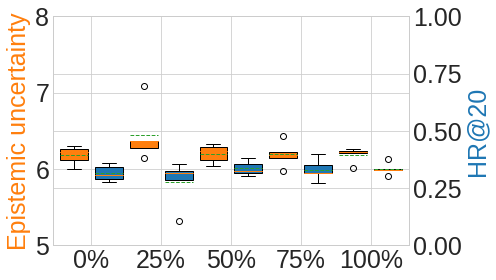

---------------------------------------------------------------------------------------
Between User Data Reduction Technique: most_active
---------------------------------------------------------------------------------------


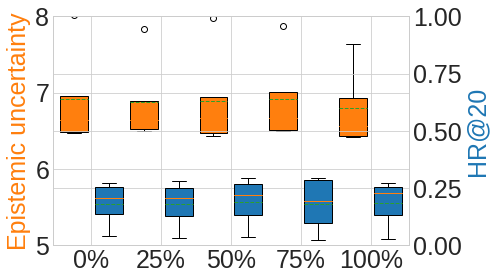

In [ ]:
### Which Between User Data Reduction Strategy Graphs will be generated
model_saved_location = '/content/drive/My Drive/RuhaniRahman/UncertaintyRecommenderSystem/results/NextItNet/epistemic_uncertainty/'

between_user_data_reduction_techniques = [
    'nicest', #[Done]
    # 'harshest', #[Done]
    'most_active', #[Done]
    # 'least_active', #[Done]
    # 'most_consistent', #[Done]
    # 'least_consistent', #[Done]
    # 'most_open_minded', #[Done]
    # 'least_open_minded', #[Done]
    # 'most_typical', 
    # 'least_typical',
]

for between_user_technique in between_user_data_reduction_techniques:
    print('---------------------------------------------------------------------------------------')
    print('Between User Data Reduction Technique:', between_user_technique)
    print('---------------------------------------------------------------------------------------')

    model_un_plots(between_user_technique, un_low=5.0, un_high=8, hr_low=0.00, hr_high=1.00)

In [ ]:
# @deprecated("use the new function")
# def model_un_plots(model_name):
#     with open(model_saved_location + model_name,'rb') as f:
#         metrics = pickle.load(f)
#     plt.figure(figsize=(15,5))
#     plt.subplot(121)
#     plt.title('%s_model_un'%model_name)
#     plt.boxplot([metrics[0,:,1], metrics[1,:,1], metrics[2,:,1], metrics[3,:,1], metrics[4,:,1]], meanline=True, showmeans=True)
#     plt.subplot(122)
#     plt.title('%s_hr@20'%model_name)
#     plt.boxplot([metrics[0,:,0], metrics[1,:,0], metrics[2,:,0], metrics[3,:,0], metrics[4,:,0]], meanline=True, showmeans=True)
#     plt.show()

### Figure 6: 
Epistemic Uncertainty Change vs. user characteristics


> Take each users uncertainty results caculated in the montecarlo_prediction method. The non-targeted users uncertainty results would be 0. e.g. for nicest users, non-targeted users are those whose average rating is less the threshold (7.5). The nicest users will have some epistemic uncertainty. Save that information in a file and plot the graphs with their average ratings.
> * x-axis is the uncertainty value of the user<br>
> np.log(model_uncertainty of the user/model_uncertainty of the user for a full model)
> * y-axis is the average value of the ratings of that user




In [ ]:
def plot_delta_model_un(retained_parcent, between_user_data_reduction_strategy_name='nicest', color='blue'):
    # load full model un_model_full
    threshold = between_users[between_user_data_reduction_strategy_name]['threshold']
    isMost = between_users[between_user_data_reduction_strategy_name]['isMost']
    split_array = between_users[between_user_data_reduction_strategy_name]['split_array']
    x_label = between_users[between_user_data_reduction_strategy_name]['x_label']

    print(between_user_data_reduction_strategy_name, threshold, isMost, split_array)

    location = model_saved_location + between_user_data_reduction_strategy_name + '_user_ep_un_%.2f'%(retained_parcent)
    location_full = model_saved_location + between_user_data_reduction_strategy_name + '_user_ep_un_1.00'
    # split_array = np.array([np.mean(data.user_ratings[user_id]) for user_id in range(data.num_users)])

    with open(location_full, 'rb') as f:
        un_model_full = pickle.load(f)
    with open(location, 'rb') as f:
        un_model_par = pickle.load(f)
    idx = np.where(un_model_par != 0)[0]
    print('X values', split_array[idx])
    plt.figure(figsize=(8,4))
    plt.plot(split_array[idx], np.log(np.divide(un_model_par[idx], un_model_full[idx])),  '.', color=color)
    plt.ylabel('Difference of\nepistemic uncertainty:\nlog(' + between_user_data_reduction_strategy_name +'('+str(retained_parcent*100)+'%)/Full)',fontsize=25)
    plt.xlabel(x_label,fontsize=25)
    plt.ylim(-1,1)
    #     #plt.show()
    # else:
    #     plt.plot(x_similarity[idx], np.log(np.divide(un_model_par[idx], un_model_full[idx])),  '.', color=color)
    #     plt.ylabel('Difference of\nepistemic uncertainty:\nlog('+ " ".join(file_name.split('_')[:-1]) + ' (50%)/Full)',fontsize=25)
    #     plt.xlabel('Average user similarity to all other users',fontsize=25)
    #     plt.ylim(-5,5)
    #     #plt.show()
    plt.show()

---------------------------------------------------------------------------------------
Technique: nicest --> Retained Parcentage: 0.25
---------------------------------------------------------------------------------------
nicest 7.5 True [8.37735849 7.42635659 7.80392157 ... 8.16528926 7.625      6.92134831]
X values [8.37735849 7.80392157 8.38095238 ... 8.21818182 8.16528926 7.625     ]


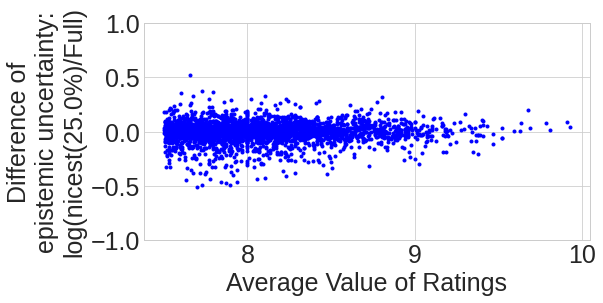

---------------------------------------------------------------------------------------
Technique: most_active --> Retained Parcentage: 0.25
---------------------------------------------------------------------------------------
most_active 100.0 True [ 53 129  51 ... 121  32  89]
X values [129 198 139 ... 165 153 121]


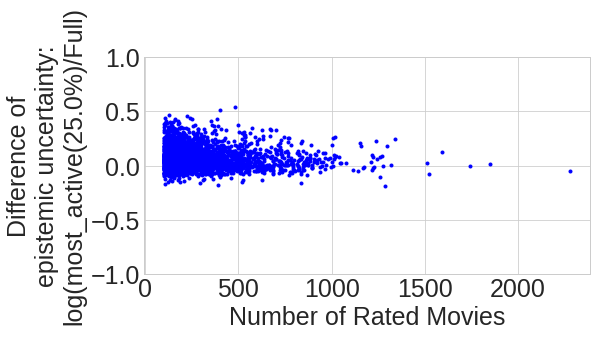

In [ ]:
between_user_data_reduction_techniques = [
    'nicest', #[Done]
    # 'harshest', #[Done]
    'most_active', #[Done]
    # 'least_active', #[Done]
    # 'most_consistent', #[Done]
    # 'least_consistent', #[Done]
    # 'most_open_minded', #[Done]
    # 'least_open_minded', #[Done]
    # 'most_typical', 
    # 'least_typical',
]

retained_user_parcentages = [
    # 1.00,
    # 0.75, 
    # 0.50, 
    0.25, 
    # 0.00
]

for between_user_technique in between_user_data_reduction_techniques:
    for ind, retained_parcent in enumerate(retained_user_parcentages):
        print('---------------------------------------------------------------------------------------')
        print('Technique:', between_user_technique, '--> Retained Parcentage:', retained_parcent)
        print('---------------------------------------------------------------------------------------')

        plot_delta_model_un(
                                retained_parcent=retained_parcent, 
                                between_user_data_reduction_strategy_name=between_user_technique,
                                color = 'blue'
                            )


In [6]:
train, validation, test = spliter.split_data(fold_id=3)

(450972, 1) (104477, 1) (4832,) (1208, 1)


In [11]:
test.sequences[0]

array([ 217, 2447, 1634, 2540, 1069, 1378, 3218,  982, 2512, 2686, 2984,
       3187, 1690, 1631, 1029, 1125, 1960,  343, 2889,   44,  415,  909,
        407, 1486, 2513, 1811, 3156, 1065, 1035, 3101, 2805,  862, 2325,
        895, 2380, 1020, 1931,  285, 1579, 2459, 1039, 2981, 2887, 1048,
       1026, 1062,  769, 1106, 1052, 1149,  998, 2471,  547,  802, 2888,
       3056, 3111,  272,  869, 1007, 3008, 1265,  875,  698, 1409, 2890,
       1786,   25, 1436, 1764, 1267, 1746,  553, 2544, 3319, 2346,  889,
        296, 2621,    1, 2775, 2160,  919, 1077, 1049, 3186, 1023,  105,
       3084, 1086, 1113,  916, 2652,  789, 1092, 1399,  548, 1064, 1670,
       2545], dtype=int64)

In [27]:
np.atleast_2d(np.arange(data.sequence_length))

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
        80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
        96, 97, 98, 99]])

In [52]:
x = np.array([[1, 2, 3], 
    [2, 3, 4] ,
    [3, 4, 5]])
print(x.shape)
np.random.permutation(x, axis = 1)

(3, 3)


TypeError: RandomState.permutation() takes no keyword arguments

In [56]:
s = np.arange(16).reshape(4, 4)
np.take_along_axis(s, np.random.randn(*s.shape).argsort(axis=1), axis=1)

array([[ 1,  3,  2,  0],
       [ 6,  5,  4,  7],
       [ 8, 11, 10,  9],
       [12, 13, 15, 14]])

In [63]:
x = np.repeat(np.atleast_2d(np.arange(data.sequence_length)), test.sequences.shape[0], axis=0)
print(x.shape)
x = np.take_along_axis(x, np.random.randn(*x.shape).argsort(axis=1), axis=1)[:, :10]
print(x.shape)

(1208, 100)
(1208, 10)


In [67]:
new_sequences = np.zeros(test.sequences.shape)
print(new_sequences.shape)
# print(new_sequence)
random_indices = np.repeat(np.atleast_2d(np.arange(data.sequence_length)), test.sequences.shape[0], axis=0)
random_indices = np.take_along_axis(random_indices, np.random.randn(*random_indices.shape).argsort(axis=1), axis=1)[:, :10]

# # x.sort()
print(random_indices.shape)
new_sequences[random_indices] = test.sequences[:, random_indices]
print(new_sequences.shape)

(1208, 100)
(1208, 10)


ValueError: shape mismatch: value array of shape (1208,1208,10) could not be broadcast to indexing result of shape (1208,10,100)

In [20]:
test.sequences[0, x]

array([ 217,  407, 1020, 2459, 1007, 2544, 2346,  296, 1049, 1399],
      dtype=int64)